In [ ]:
# import requests
# from IPython.core.display import HTML
# HTML(f"""
# <style>
# @import "https://cdn.jsdelivr.net/npm/bulma@0.9.4/css/bulma.min.css";
# </style>
# """)

# Gaze estimation
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">
This is the first mandatory exercise which means you will have to hand in this Jupyter Notebook with your implementation and notes. This exercise is split into multiple parts which have to be submitted together. The submission deadline is available on LearnIT.

</div>

<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">
<article class="message">
    <div class="message-body">
        <strong>Overview of mandatory tasks</strong>
        <ul style="list-style: none;">
            <li>
            <a href="#visualization">Task 1: Visualisation 1</a>
            </li><li>
            <a href="#visualisation2">Task 2: Visualisation 2</a>
            </li><li>
            <a href="#task_model">Task 3: Implement a gaze model</a>
            </li><li>
            <a href="#evaluation">Task 4: Model evaluation</a>
            </li><li>
            <a href="#improvements">Task 5: Model improvements</a>
            </li><li>
            <a href="#glints">Task 6: Glints</a>
            </li>
        </ul>
    </div>
</article>

</div>

## Overview
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">
**Note:** The location of the _fovea_ on the retina varies between people ($\pm$ 5 degrees). Consequently, a gaze model has to be trained (calibrated) for a specific person to be accurate. This difference is shown in [Figure 1](#kappa).


In this exercise you will implement a regression model to estimate where a person is looking (this is known as _gaze_). Gaze estimation is performed by capturing images of a user’s eye as shown in [Figure 2](#model) and mapping them to screen positions using a function $f_\mathbf{w}(x, y)$. Humans look at things by orienting their eyes so that the light from the point of focus hits the _Fovea_ (a point on the retina). The Fovea is not located directly behind the pupil, but at a person-specific angle, as shown in [Figure 1](#kappa). The pupil position can be used to infer gaze, but to obtain accurate gaze estimates requires training data (called calibration).

</div>

<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">
<div style="float: left; width: 50%; justify-content: start" class="block is-clearfix">
<figure class="figure" id="kappa">

<img src="/resources/material/W05/kappa.jpg" class="figure-img img-fluid rounded" style="width:100%" />

<figcaption class="figure-caption has-text-left">Figure 1: Shows the distinction between the visual and optical axes. The optical axis is defined as an axis perpendicular to the lens behind the pupil. The visual axis is personally dependent and is determined by the placement of the *fovea*.</figcaption>
</figure>


</div>

<div style="float: right; width: 50%; justify-content: start" class="block is-clearfix">
<figure class="figure" id="model">

<img src="/resources/material/W05/model.png" class="figure-img img-fluid rounded" style="width:100%" />

<figcaption class="figure-caption has-text-centered">Figure 2: Diagram of a gaze estimation system. The eye, which is directed at a specific point on
    the screen is captured by the camera. The two red lines represent an unknown transformation from image
    to eye and eye to screen. We learn this transformation directly which is shown as $f_{\mathbf{w} }(x, y)$ in the diagram.</figcaption>
</figure>


</div>


</div>

### Gaze mapping function
The goal of this exercise is to estimate the gaze of image sequences using a regression model. Define $f_{\mathbf{w}}(x, y)$ as the gaze  model which maps pupil positions $(x, y)$ to screen coordinates $(x', y')$. The model parameters $\mathbf{w}$ are learned using a set of paired pupil and screen positions. 
### About data
We provide a dataset of training and test data. The data has been captured by asking a participant to look at a specific point on a screen while capturing eye images. The pupil shape is detected for each image using ellipse approximation. The ellipses are parametrised by five parameters, `cx, cy, ax, ay, angle`
. The center of the ellipse is assumed to be the center of the pupil.
Each image sequence contains 9 images for calibration and a varying number of images for testing. The calibration samples always represent the same 9 screen positions which form a simple 3 by 3 grid. An example of calibration images are shown in [Figure 3](#calibration). For each sequence, you will use the 9 calibration samples to train a regression model and then use the model
to predict gaze positions for the rest of the images.
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">
<figure class="figure" id="calibration">

<img src="/resources/material/W05/calibration.jpg" class="figure-img img-fluid rounded" style="width:500px" />

<figcaption class="figure-caption has-text-centered">Figure 3: Calibration images. All image sequences contain 9 calibration images
which all have equivalent gaze positions.</figcaption>
</figure>


</div>

**Note:** The real notebook (the one in the materials repository) contains some extra utility code that has been hidden here for brevity. The code is fully commented and we recommend you read it whenever you are in doubt about what is happening.




In [1]:
import os
import json
import numpy as np
from matplotlib.patches import Ellipse
from skimage import io

import matplotlib.pyplot as plt

In [2]:
def load_json(folder, filename):
    """Load json file from subdirectory in "inputs/images" with the given filename
    - without .json extension!

    Returns: The json data as a dictionary or array (depending on the file).
    """
    with open(os.path.join(os.path.abspath('data/gaze/' + folder), f'{filename}.json')) as file:
        data = json.load(file)
        return data

def create_pupil_data(json_input):
    raw = [[line["cx"], line["cy"], line["ax"], line["ay"], line["angle"]] for line in json_input]
    return np.array(raw)

def create_position_data(json_input):
    raw = np.array(json_input)[:, [1, 0]]
    return np.array(raw)

def create_glint_data(json_input):
    return np.array(json_input)
   
def center_crop(img, size):
    width, height = size
    i_height, i_width = img.shape[:2]

    dy = (i_height-height)//2
    dx = (i_width-width)//2

    return img[dy: i_height-dy, dx: i_width-dx], (dx, dy)

In [3]:
def open_img(path, idx):
    """Open a single image from the provided path. The index specifies the image name."""
    img = io.imread(path + f'/{idx}.jpg')
    if img is None:
        raise IOError("Could not read image")
    return img

def show_example_features(dataset):
    """Draw a grid of images with the predicted pupils drawn on top."""
    images = dataset["images_test"]
    pupils = dataset["pupils_test"]
    if dataset.get("glints_test") is not None:
        glints = dataset["glints_test"]
    else:
        glints = None
        
    n = len(images)
    cols = 8
    rows = n//8+1

    fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, d in enumerate(images):
        img = d.copy()
        row = pupils[i]
        cropped, (dx, dy) = center_crop(img, (250, 250))
        ax[i//cols, i%cols].imshow(cropped)
        ellipse = Ellipse((row[0]-dx, row[1]-dy), width=row[2], height=row[3], angle=row[4], edgecolor="r", fill=None, linewidth=2)
        ax[i//cols, i%cols].add_patch(ellipse)
        
        if glints is not None:
            gs = glints[i]
            xs = gs[:, 0] - dx
            ys = gs[:, 1] - dy
            ax[i//cols, i%cols].scatter(xs, ys, marker="x")
            # for g in gs:
            #     img = cv.drawMarker(img, (int(g[0]), int(g[1])), (0, 255, 0), cv.MARKER_CROSS, 20, 3)
        
    for row in ax:
        for a in row:
            a.get_xaxis().set_visible(False)
            a.get_yaxis().set_visible(False)
    plt.show()
    
def plot_positions(data):
    """Scatter plot of the points in data"""
    plt.scatter(data[:, 0], data[:, 1])

## Data and visualization
The data for the assignment consists of datasets $\mathcal{D}_{p0}, \mathcal{D}_{p1}, \mathcal{D}_{p2}, \mathcal{D}_{p3}$ where each correspond to a single recording session. The sources for each dataset is found in the subfolders of the `data/gaze`
 folder. 
First you will familiarise yourself with the problem domain and data sources by doing a number of visualisations. 
The code below loads each dataset $\mathcal{D}_i$ . The `show_example_features`
 function then plots a grid of all the images from one of the datasets. 

---
**Task 1 (easy): Visualisation 1👩‍💻**
1. Test the visualisation for different datasets (by changing the array index when accessing images, positions, or pupils).


---


In [4]:
# Enter dataset folder name here (any subfolder in inputs/images will do)
dataset_folders = ['0', '1', '2', '3']

D = []

for f in range(4):
    pupils = create_pupil_data(load_json(str(f), 'pupils'))
    positions= create_position_data(load_json(str(f), 'positions'))
    images = [open_img(os.path.abspath('data/gaze/' + str(f)), i) for i in range(len(positions)-1)]
    D.append({
        "pupils_train": pupils[:9],
        "pupils_test": pupils[9:],
        "positions_train": positions[:9],
        "positions_test": positions[9:],
        "images_train": images[:9],
        "images_test": images[9:],
    })


**Details about the data format**
Each dataset $\mathcal{D}_i$, or `D[i]`
 in code, contains a dictionary of training and test data.
The dataframes each contain a number of columns. Here’s a description of what data each column contains.
**Dataset elements:**
- `pupils_train`
: Detected pupil positions for the 9 calibration images.
- `pupils_test`
: Detected pupil positions for the test images.
- `positions_train`
: Screen target positions for the 9 calibration images.
- `positions_test`
: Screen target positions for the test images.
- `images_train`
: 9 calibration images.
- `images_test`
: Test images.

**Array content:**
The _pupil_ data is stored in $N\times 5$ arrays where $N$ is the number of pupils. Each row contains the five ellipse parameters for the pupil as described above. The _positions_ data is stored in $N\times 2$ arrays where each row is the $x, y$ position of the gaze target.




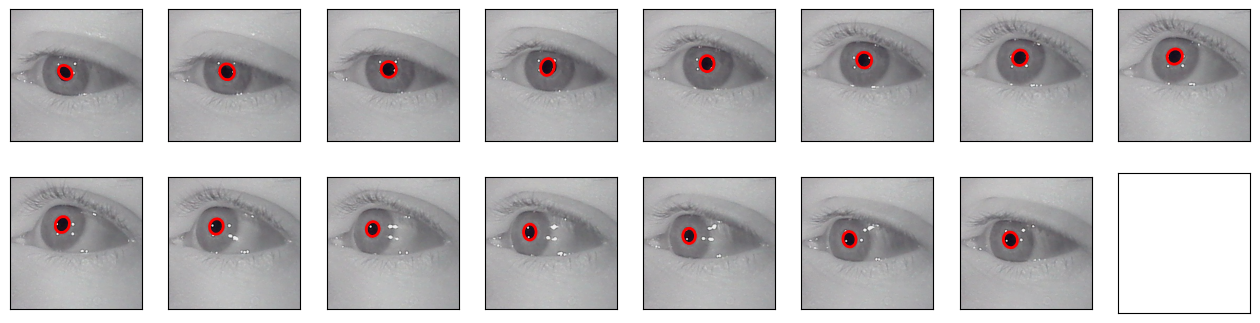

In [7]:
show_example_features(D[1])

### Visualization of dataset
The code below visualizes the recorded screen gaze positions. The subject was instructed to look at a red dot on a specific point on a screen while the camera captured each image.


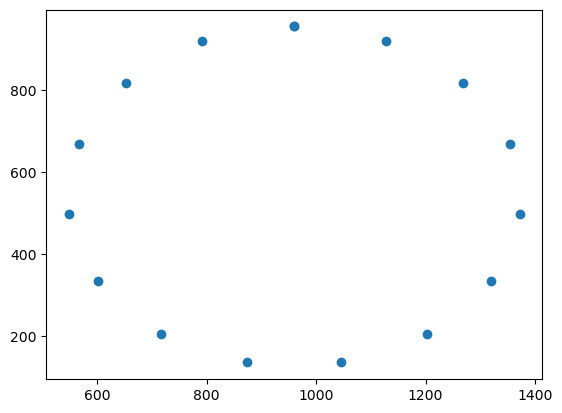

In [8]:
plot_positions(D[1]["positions_test"])


---
**Task 2 (easy): Visualisation 2👩‍💻💡**
The following tasks intend to help you understand how the pupil and screen positions are related visually.
1. Modify `idx`
 in the cell above to visualize the screen positions for the different test sets.
2. Plot the detected pupil positions for the corresponding dataset in the cell below using the same method but replacing `positions_test`
 with `pupils_test`
.
3. Describe at least two potential reasons for why the shape of the pupil positions are different from the shape of the screen positions.


---

### Answer to question 3
One reason could be inaccuracies in the measurements. While we know the exact pixel positions of the red dot on a screen, we cannot measure the eyes position precisely using only an image

Another reason might TODO:

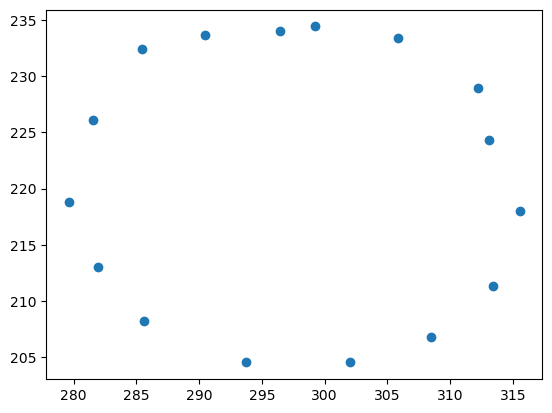

In [9]:
# Write the plotting code here (using Seaborn is easier, but feel free to use Matplotlib as well)
plot_positions(D[1]["pupils_test"])

## Implement a gaze estimation model
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">
<div style="float: right; width: 25%; justify-content: start" class="block is-clearfix">
<figure class="figure" id="gaze">

<img src="/resources/material/W05/gaze2.jpg" class="figure-img img-fluid rounded" style="width:150px" />

<figcaption class="figure-caption has-text-centered">Figure 4: Point mapping. (top) Three points in screen coordinates. (middle) screen and eye $x$ coordinates for the same three points. (bottom) screen and eye $y$ coordinates for the same points.</figcaption>
</figure>


</div>

The mapping function $f_\mathbf{w}(x, y)$ is unknown. Because the pupil moves in a spherical curve (this is only true when the head is fixed), the relationship between pupil position in the image and gaze is non-linear. For now, however, you will approximate the gaze mapping by a linear function. Because the function has two outputs (an $x'$ and a $y'$ coordinate), it is easier to train one model for each coordinate, although you can also combine both into a single model with the same result. You do this as in the previous exercises but with one model for the $x$ coordinate and one for the $y$ coordinate. To get the screen coordinates $x'$, $y'$ we have

$$
\begin{aligned}
x' &= ax + by + c\\
y' &= dx + ey + f.
\end{aligned}
$$

The principle is demonstrated in [Figure 4](#gaze) to the right. Here, the $x$ coordinate of the pupil maps to the $x$ coordinate on the screen. In the real model, we use both $x$ and $y$ as inputs to both the model estimating the $x$ position on the screen and the model estimating the $y$ position.

</div>


---
**Task 3 (medium): Implement a gaze model👩‍💻♾️**
1. ✏️ **Construct the design matrix** Write down design matrices for both equations above. Use the previous exercise previous exercise
 as a guideline. Answer the following:
    - What are the knowns and unknowns in the equations?
    - How many parameters does the model have?
    - How many points (pupil to gaze point correspondances) do we need to solve the equations?
    - What effect does the number of points used have on the solution?


2. 🖥️ **Implement the design matrix:** Implement a function for generating a design matrix from pupil positions.

3. 🖥️ **Calibration:** Learn the parameters $\mathbf{w}$ for each dataset $\mathcal{D}_i$. Use the `pupils_train`
 and `positions_train`
 arrays as training data. Create a design matrix from the pupil positions. Use _two_ linear models, as described above, one to learn the X-coordinates and one to learn the Y-coordinates. 


**Note:** This is possibly the most difficult part of the exercise. Try to use what you learned in the two non-mandatory exercises (Experimenting with the tutorial
 and Polynomial regression
) and apply it here. Remember that you need to fit two separate models, one for each screen coordinate.


4. 🖥️ **Estimation:** Implement a function which predicts the gaze point given a pupil position using the learned models. For reference, the linear model has the form $f_\mathbf{w}(x)=\mathbf{w}_0 x_0 + \mathbf{w}_1 x_1 + \mathbf{w}_2$. You may calculate the point for each coordinate seperately. Then calculate and return the estimated screen coordinates using the models created during calibration.

**Note:** **Important!** Don’t expect the linear model to perform particularly well. Expect the distances between true and predicted gaze points to vary by $\pm 200$ pixels.



---

### 1
First let's make the design matrix (A) of the two equations in the form of $Aw = b$ using the minimum amount of points needed

$$
x' = ax + by + c =
\begin{bmatrix}
x_1 & y_1 & 1 \\
x_2 & y_2 & 1 \\
x_3 & y_2 & 1 \\
\end{bmatrix}
\begin{bmatrix}
a \\ 
b \\
c \\
\end{bmatrix}
\\ 
y' = dx + ey + f =
\begin{bmatrix}
x_1 & y_1 & 1 \\
x_2 & y_2 & 1 \\
x_3 & y_2 & 1 \\
\end{bmatrix}
\begin{bmatrix}
d \\ 
e \\
f \\
\end{bmatrix}
$$

The unknowns are a, b, c, d, e and f

The knowns are x', y', x and y

Depending on how you create the models, you either have:
- 2 models with 3 parameters each. Model 1 with parameters a, b and c and model 2 with parameters d, e and f
- 1 model with 6 parameters a, b, c, d, e and f

We need a minimum of 3 points, in order for the dimension of A and w to fit (TODO: maybe 2?)

Using more points should increase the accuracy of the model, as noise would effect the model less when more points are used (TODO:)

In [12]:
def get_design_matrix(pupil_positions):
    data_points = []

    for i in range(len(pupil_positions)):
        position = pupil_positions[i]

        data_points.append([position[0], position[1], 1])

    return np.array(data_points)

def determine_parameters(design_matrix, pupils, x_or_y):
    x_or_y_values = []
    if (x_or_y == 'x'):
        x_or_y_values = pupils[:, 0]
    else:
        x_or_y_values = pupils[:, 1]


    temp_parameters = np.linalg.inv(design_matrix.transpose() @ design_matrix) @ design_matrix.transpose() @ x_or_y_values

    return np.array([
        [temp_parameters[0]],
        [temp_parameters[1]],
        [temp_parameters[2]]
    ])

def gaze_model_estimation(pupils_train, pupils_test, positions_train):
    design_matrix = get_design_matrix(pupils_train)
    x_prime_parameters = determine_parameters(design_matrix, positions_train, 'x')
    y_prime_parameters = determine_parameters(design_matrix, positions_train, 'y')

    pupils_test_prepared = get_design_matrix(pupils_test)

    return np.hstack((pupils_test_prepared @ x_prime_parameters, pupils_test_prepared @ y_prime_parameters))

## Evaluation of the regression model


In [13]:
def calculate_rmse_mae(gaze_model, positions_test):
    y_predicted = gaze_model[:, 1:]
    y_actual = positions_test[:, 1:]
    length = y_predicted.shape[0]
    diff = y_predicted - y_actual

    rmse = np.sqrt((1 / length) * (diff @ diff.transpose()).sum())
    mae = (1 / length) * np.sum(np.abs(diff))

    return (rmse, mae)

gaze_model_D0 = gaze_model_estimation(D[0]['pupils_train'], D[0]['pupils_test'], D[0]['positions_train'])
gaze_model_D1 = gaze_model_estimation(D[1]['pupils_train'], D[1]['pupils_test'], D[1]['positions_train'])
gaze_model_D2 = gaze_model_estimation(D[2]['pupils_train'], D[2]['pupils_test'], D[2]['positions_train'])
gaze_model_D3 = gaze_model_estimation(D[3]['pupils_train'], D[3]['pupils_test'], D[3]['positions_train'])

rmse_D0, mae_D0 = calculate_rmse_mae(gaze_model_D0, D[0]['positions_test'])
rmse_D1, mae_D1 = calculate_rmse_mae(gaze_model_D1, D[1]['positions_test'])
rmse_D2, mae_D2 = calculate_rmse_mae(gaze_model_D2, D[2]['positions_test'])
rmse_D3, mae_D3 = calculate_rmse_mae(gaze_model_D3, D[3]['positions_test'])
rmse = [rmse_D0, rmse_D1, rmse_D2, rmse_D3]
mae = [mae_D0, mae_D1, mae_D2, mae_D3]


---
**Task 4 (medium): Model evaluation👩‍💻💡**
In the following you have to evaluate the performance of your models. Each individual task should be repeated for all datasets ($\mathcal{D}_{0}, \mathcal{D}_{1}, \mathcal{D}_{2}, \mathcal{D}_{3}$). It is important that the results are calculated for all datasets simultaneously because you have to use the results later in the assignment.
1. 🖥️ **Calculate errors:** 
    - Predict gaze positions for the test pupils in `pupils_test`
.
    - Calculate the _root-mean-square error_ (_rmse_) between the true values in `positions_test`
 and the predictions.
    - Calculate the _mean absolute error_ (_mae_) as well.


2. 🖥️ **Create visualizations:**: 
    - Make a scatterplot of the predicted positions and ground-truth positions. You may use the `plot_positions`
 helper function.
    - Make a scatterplot of the errors using the same method.


3. 🖥️ **Evaluate:**
    - Determine whether the _mae_ or _rmse_ is most useful for evaluating the precision of the gaze models. Explain your answer.
    - Identify at least 3 potential sources of error associated with the current linear model. Describe how each source of error contributes to the prediction error.




---


In [14]:
def plot_results(predicted, ground_truth):
    """Plot prediction results with numbers and arrows indicating prediction/ground_truth 
    pairs.
    
    Args:
        predicted: Nx2 array of predicted points. 
        ground_truth: Nx2 array of ground_truth points.
    """
    fig, ax = plt.subplots(1, 1)
    
    dx = predicted[:, 0] - ground_truth[:, 0]
    dy = predicted[:, 1] - ground_truth[:, 1]
    ax.quiver(ground_truth[:, 0], ground_truth[:, 1], dx, dy, scale=1, angles='xy', scale_units='xy')
    
    ax.scatter(predicted[:, 0], predicted[:, 1], label="Prediction")
    ax.scatter(ground_truth[:, 0], ground_truth[:, 1], label="Ground truth")
    
    for i in range(predicted.shape[0]):
        ax.annotate(i, (predicted[i, 0], predicted[i, 1]))
        ax.annotate(i, (ground_truth[i, 0], ground_truth[i, 1]))
    
    plt.legend()
    plt.title('Ground truth and predictions')
    plt.show()

## Model vs ground truth

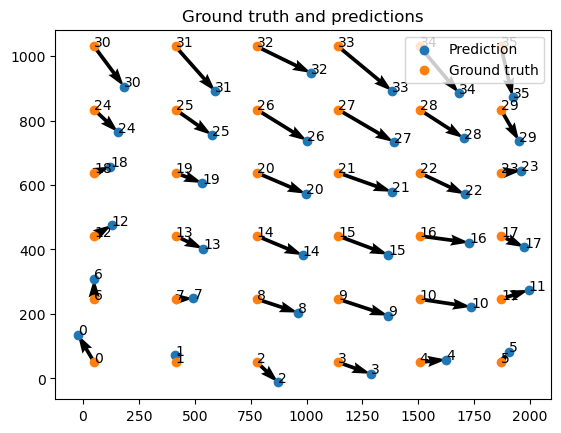

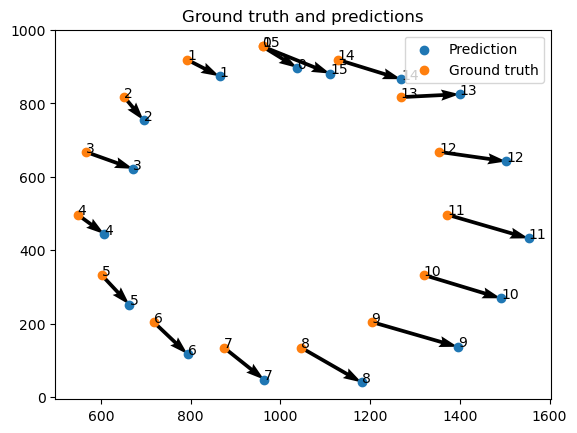

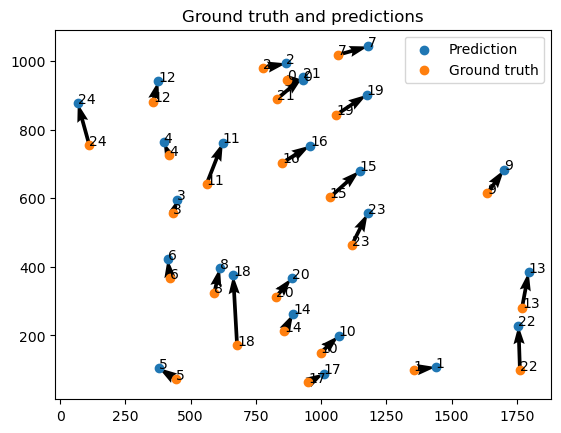

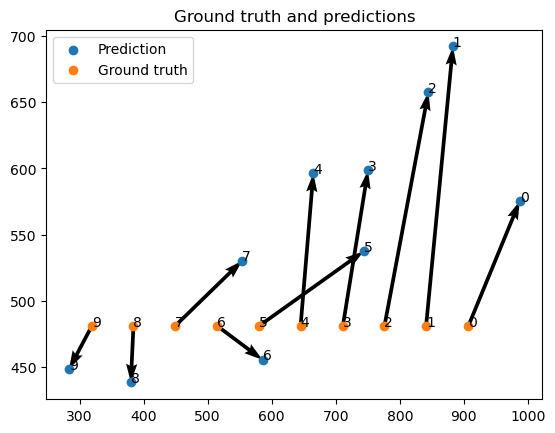

In [15]:
plot_results(gaze_model_D0, D[0]["positions_test"])
plot_results(gaze_model_D1, D[1]["positions_test"])
plot_results(gaze_model_D2, D[2]["positions_test"])
plot_results(gaze_model_D3, D[3]["positions_test"])

## Scatter plot of errors

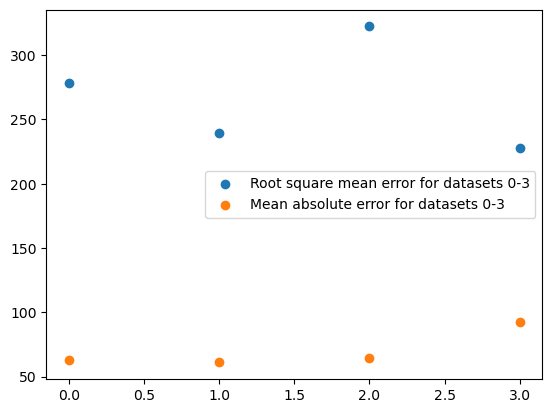

In [16]:
plt.scatter([0, 1, 2, 3], rmse, label='Root square mean error for datasets 0-3')
plt.scatter([0, 1, 2, 3], mae, label='Mean absolute error for datasets 0-3')
plt.legend()
plt.show()

## Answers 3. evaluate
    - Determine whether the _mae_ or _rmse_ is most useful for evaluating the precision of the gaze models. Explain your answer.
    - Identify at least 3 potential sources of error associated with the current linear model. Describe how each source of error contributes to the prediction error.

Though mae has a lower error rate, rmse is better for evaluating gaze models. This is due to mae weights all errors equally while rmse weights large errors more. With gaze models we don't want to punish small errors, as these can be caused by small jitters in the eyes, but we want to punish large deviation, as this might be due to the person blinking

Here's 3 possible source of errors with the current linear model:
1. A linear model might not be the right fit for a gaze model, and a more complex model might perform better
2. The quality of the image might not be high enough to precise track the iris location
3. 


## Improve the model
This final part of the exercise requires you to modify your linear model $g_{\mathbf{w}}(x,y)$ into a quadratic model. As in [Task 3](#task_model), you will create one model for each output coordinate, i.e. $x', y'$. 
**Note:** In this exercise you create one model for each output coordinate seperately but it is possible to create a single model that simultaneously maps the $x'$- and $y'$-coordinates. However, we leave it as an optional exercise for you to figure out how to do this. Hint: You have to combine the design and parameter matrices.


Since the model is two-dimensional, the quadratic polynomial has a few more factors than for one dimension. The equation for each axis is:

$$
f(x, y) = a\cdot x^2 + b\cdot y^2 + c\cdot xy + d\cdot x + e\cdot y + f.
$$

The design matrices then have the following form:

$$
D_x = D_y = \begin{bmatrix}
 		x_1^2 & y_1^2 & x_1y_1 & x_1 & y_1 & 1\\
  		x_2^2 & y_2^2 & x_2y_2 & x_2 & y_2 & 1\\
  		\vdots &&&&& \\
   		x_2^2 & y_2^2 & x_ny_n & x_n & y_n & 1\\
 	\end{bmatrix}.
$$


---
**Task 5 (medium): Model improvements👩‍💻💡**
1. 🖥️ **Implement model:** Implement the 2. order model and train it (calibrate) on each dataset.

2. ✏️ **Evaluate:** Repeat the evaluation steps you did for the linear model above in [Task 4](#evaluation) (subtask 1-2). Additionally:
    - Create a barplot of the _rmse_ of both models for each dataset. Use the `bar_comparison_plot`
 function. 


3. 🖥️ **Compare with linear results:**
    - Is there a significant difference between the _rmse_’s of the linear and 2. order models? Explain why either is the case. Use your previous discussion of model limitations and error sources in your explanation.
    - Compare the scatter plots for the predictions vs. ground-truth for both models. Is there a qualitative difference in performance in some instances? Explain why either model performs better in particular cases and relate your answer to the previous question.




---


In [18]:
def bar_comparison_plot(rmses_linear, rmses_quad):
    """Draw a bar chart comparing two sets of RMS errors.
    
    Args:
        rmses_linear: Results from the linear model.
        rmses_quad: Results from the quadratic model.
    """
    width = 0.3
    datasets = ["p0", "p1", "p2", "p3"]
    bx = np.arange(len(datasets))
    plt.bar(bx, rmses_linear, width, label="Linear") 
    plt.bar(bx + width, rmses_quad, width, label="Quadratic") 
    plt.xticks(bx + width/2, datasets)
    plt.title("RMSE for the linear and quadratic model")
    plt.legend()
    plt.show()

# Write your implementation here
def get_design_matrix_2(pupil_positions):
    data_points = []

    for i in range(len(pupil_positions)):
        position = pupil_positions[i]
        x = position[0]
        y = position[1]

        data_points.append([x**2, y**2, x*y, x, y, 1])

    return np.array(data_points)

def determine_parameters_2(design_matrix, pupils, x_or_y):
    x_or_y_values = []
    if (x_or_y == 'x'):
        x_or_y_values = pupils[:, 0]
    else:
        x_or_y_values = pupils[:, 1]


    temp_parameters = np.linalg.inv(np.transpose(design_matrix) @ design_matrix) @ np.transpose(design_matrix) @ x_or_y_values

    return np.array([
        [temp_parameters[0]],
        [temp_parameters[1]],
        [temp_parameters[2]],
        [temp_parameters[3]],
        [temp_parameters[4]],
        [temp_parameters[5]]
    ])

def gaze_model_estimation_2(pupils_train, pupils_test, positions_train):
    design_matrix = get_design_matrix_2(pupils_train)
    x_prime_parameters = determine_parameters_2(design_matrix, positions_train, 'x')
    y_prime_parameters = determine_parameters_2(design_matrix, positions_train, 'y')

    design_matrix_pupil_test = get_design_matrix_2(pupils_test)
    # pupils_test_x_y = pupils_test[:, :2]

    # pupil_x_y_prepared = np.hstack((pupils_test_x_y, np.ones((pupils_test_x_y.shape[0], 1))))

    return np.hstack((design_matrix_pupil_test @ x_prime_parameters, design_matrix_pupil_test @ y_prime_parameters))


In [20]:
gaze_model_2_D0 = gaze_model_estimation_2(D[0]['pupils_train'], D[0]['pupils_test'], D[0]['positions_train'])
gaze_model_2_D1 = gaze_model_estimation_2(D[1]['pupils_train'], D[1]['pupils_test'], D[1]['positions_train'])
gaze_model_2_D2 = gaze_model_estimation_2(D[2]['pupils_train'], D[2]['pupils_test'], D[2]['positions_train'])
gaze_model_2_D3 = gaze_model_estimation_2(D[3]['pupils_train'], D[3]['pupils_test'], D[3]['positions_train'])

rmse_2_D0, mae_2_D0 = calculate_rmse_mae(gaze_model_2_D0, D[0]['positions_test'])
rmse_2_D1, mae_2_D1 = calculate_rmse_mae(gaze_model_2_D1, D[1]['positions_test'])
rmse_2_D2, mae_2_D2 = calculate_rmse_mae(gaze_model_2_D2, D[2]['positions_test'])
rmse_2_D3, mae_2_D3 = calculate_rmse_mae(gaze_model_2_D3, D[3]['positions_test'])

rmse_2 = [rmse_2_D0, rmse_2_D1, rmse_2_D2, rmse_2_D3]

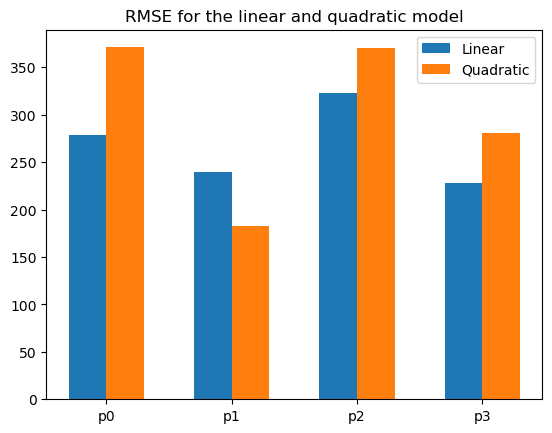

In [21]:
bar_comparison_plot(rmse, rmse_2)

## Accounting for eye movements (optional)

**Info**
The following tasks are optional but should give you significantly better gaze estimation results. You should not attempt to solve this exercise before finishing the mandatory parts of the assignment. You are also welcome to hand in the optional part if you want to get feedback on your solution.


In this exercise you will implement a method that improves your gaze estimation model using _glints_. A glint is the reflection of a light-source on the surface of the eye and is usually created using LEDs. You may have noticed that glints are already present in the provided images (otherwise check [Figure 3](#calibration)). Glints are used to derive a vector for the pupil position that is independent of the eyes location in the image. This is particularly useful for situations where the participant can move their head. If we only use the pupil, any head movement will affect to the gaze prediction which is not ideal.
For the following tasks, we include two extra datasets $\mathcal{D}_{4}$ and $\mathcal{D}_{5}$ in our collection. They where each recorded with the subject moving their head during the test positions. The glints are loaded from a file like the pupils and gaze positions. Each image has four glints (each corresponds to a light source) in an $N\times 4\times 2$ array, i.e. each image has four glints and each glint is specified by an $x, y$ position. The code cell below loads the new data:


In [ ]:
# Enter dataset folder name here (any subfolder in inputs/images will do)
dataset_folders = ['0', '1', '2', '3', '4', '5']

D = []

for f in range(6):
    pupils = create_pupil_data(load_json(str(f), 'pupils'))
    positions= create_position_data(load_json(str(f), 'positions'))
    glints = create_glint_data(load_json(str(f), 'glints'))
    images = [open_img(os.path.abspath('data/gaze/' + str(f)), i) for i in range(len(positions)-1)]
    D.append({
        "pupils_train": pupils[:9],
        "pupils_test": pupils[9:],
        "glints_train": glints[:9],
        "glints_test": glints[9:],
        "positions_train": positions[:9],
        "positions_test": positions[9:],
        "images_train": images[:9],
        "images_test": images[9:],
    })

Run the cell below to visualize the glints in one of the datasets:


In [ ]:
show_example_features(D[4])


---
**Task 6 (hard): Glints👩‍💻💡**
1. 🖥️ **Remove outliers:** The glints are not always detected reliably. This should be clear from the images above. You have to implement a method to determine whether a glint position is valid or not.
    - Filter the glints based on their distance to the pupil center. Define a threshold for which glints will be considered outliers.
    - Experiment with the threshold to find a value that removes most outliers. This is important for the calibration to work properly.


2. 🖥️ **Determine top-left glint and calculate glint-pupil vector:** For simplicity, you will only use the top-left glint in each image.
    - Find a method to determine whether the top-left glint is visible in each image. Filter out any images where this glint isn’t visible.
    - Calculate the difference vector between the pupil and top-left glint in each image. Save the result in an array for each dataset. 


3. 🖥️ **Calibrate models:**
    - Train the linear and 2. order models on the difference vectors you calculated above. For some datasets, you may not be able to train the 2. order model if some of the calibration images are missing.


4. ✏️ **Evaluate:**
    - Test the new models using the same method as in [Task 4](#evaluation) and [Task 5](#improvements)
    - Compare the results using the same steps as described in [Task 5](#improvements) (if you want feedback)
    - Try to add the $\mathcal{D}_{4}$ and $\mathcal{D}_{5}$ datasets to the original models. Compare the results with the glint-based method.




---
